# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 01/14/2022

In [1]:
#Import necessary packages

import pandas as pd #to work with data arrays
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from sklearn import metrics #to find r2 values from regression
!pip install pymannkendall
import pymannkendall as mk #used to perform mann-kendall stationarity test
from sklearn.cluster import KMeans #to cluster using kmeans
import os #for file output paths
import matplotlib.patches as mpatches
import matplotlib.lines as Line2D
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
datasets/  pod_pou_lulcc/


In [5]:
## IMPORT ALL DIVERSION FILES ##

all_files =[]
csv = glob.glob('datasets/diversion_timeseries/WRA_20220712_db206/*_history.csv')
common_name_flow = pd.read_csv('datasets/diversion_timeseries/relates/name_dictionary_flow.csv')
names = list(common_name_flow['DiversionName'])
div_dict = dict(zip(common_name_flow['HydrologyID'], common_name_flow['DiversionName']))

for f in csv:
  df = pd.read_csv(f, parse_dates=['HSTDate'], index_col=False)
  all_files.append(df)

full = pd.concat(all_files)
full['Name'] = full['SiteID'].map(div_dict)
full = full.drop(['SiteType', 'Gage Height (Feet)', 'Unnamed: 6', 'Unnamed: 5'], 
                 axis=1).rename({'Flow (CFS)': 'Diversion (cfs)',
                                 'HSTDate': 'DataDate'}, axis=1).sort_values(by='Name')
full['Acre_feet'] = full['Diversion (cfs)']*86400/43559.9

In [6]:
## DATA QUALITY CONTROL PRIOR TO ANALYSIS ##

## Find the names of all the canals in the dataframe list

names = full['Name'].unique()

## Fill in any missing winter values with 0 starting at 1987-01-01

full = full.set_index('DataDate')
dt_series = pd.date_range(start='1987-01-01', end='1987-01-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

canals = []

for i in names:
  canal = full[full['Name']== i] #selects the specific diversion dataframe
  if canal.empty:
    None
  else:
    id = canal['SiteID'][0]
    canal = pd.concat([dt_df, canal]) #adds the pandas series of dates to dataframe
    canal = canal.drop(labels=0, axis=1) #dropes the series column
    canal = canal.loc[~canal.index.duplicated(),:] #removes any duplicate index values
    canal = canal.asfreq('d') #fill each daily value
    canal['Diversion (cfs)'] = canal['Diversion (cfs)'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
    canal['Diversion (cfs)'] = canal['Diversion (cfs)'].abs()
    canal['Name'] = canal['Name'].fillna(i) #fills Nan diversion name values
    canal['SiteID'] = canal['SiteID'].fillna(id)
    canal['Acre_feet'] = canal['Acre_feet'].fillna(0)
    canals.append(canal)




In [7]:
## ----------------------------- ##
## MERGE ALL DATAFRAMES INTO ONE ## 
## ----------------------------- ##

full_df = pd.concat(canals)
names = full_df['Name'].unique()

full_df['Year'] = full_df.index.year
full_df['Month'] = full_df.index.month
full_df['DayofYear'] = full_df.index.dayofyear
full_df = full_df[full_df['Year'] <= 2021]

In [8]:
## Survival Analysis Data Gathering ##
## -------------------------------- ##

# Calculate the cumulative sum of the data

full_df['Sum'] = full_df.groupby(['Name','Year']).Acre_feet.cumsum()

# Calculate the start and end day of the irrigation season for each canal

names = full_df['Name'].unique()
years = full_df['Year'].unique()
df_start = pd.DataFrame()
df_end = pd.DataFrame()

andrews = full_df[(full_df['Name'] == 'ANDREWS CANAL') & (full_df['Year'] == 1990)]
end = andrews.loc[andrews['Sum'] == max(andrews['Sum'])].head(1)

for i in names:
  sub = full_df[full_df['Name'] == i]
  for y in years:
    sub_year = sub[sub['Year'] == y]
    start = sub_year.loc[sub_year['Sum']>0].sort_values(by = 'DayofYear').head(1)
    df_start = pd.concat([df_start,start])
    end = sub_year.loc[sub_year['Sum'] == max(sub_year['Sum'])].head(1)
    df_end = pd.concat([df_end,end])

df_start = df_start.reset_index()
df_end = df_end.reset_index()

df_start = df_start[['index', 'Year', 'Name', 'DayofYear']].rename({'index': 'StartDate',
                                                                    'DayofYear': 'StartDayofYear'}, axis = 1)
df_end = df_end[['index', 'Year', 'Name', 'DayofYear']].rename({'index': 'EndDate',
                                                                'DayofYear': 'EndDayofYear'}, axis = 1)

# Create a dataframe used for survival analysis
survival = df_start.merge(df_end, left_on = ['Name', 'Year'], right_on = ['Name', 'Year'])
survival['Time'] = survival['EndDayofYear'] - survival['StartDayofYear'] # time to event
survival.loc[survival['StartDayofYear'] < 60, 'Censor'] = 'Left' # left censored
survival.loc[survival['EndDayofYear'] > 319, 'Censor'] = 'Right' # right censored
survival.loc[(survival['EndDayofYear'] < 319) & (survival['StartDayofYear'] > 60), 'Censor'] = 'No' # No censor


In [9]:
## Cropping start and end of irrigation season ##
## ------------------------------------------- ##

# Determine the earliest start dates after Mar. 1 
# and the latest end dates before Nov. 15 

s_dates = pd.DataFrame()
e_dates = pd.DataFrame()

for i in survival['Year'].unique():
  sub = survival[survival['Year'] == i]
  s_dates = pd.concat([s_dates, sub.loc[sub['StartDayofYear'] > 60].sort_values(by = 'StartDayofYear').head(1)])
  e_dates = pd.concat([e_dates, sub.loc[sub['EndDayofYear'] < 319].sort_values(by = 'EndDayofYear', ascending = False).head(1)])

# Merge into one dataframe

s_dates = s_dates[['StartDate', 'StartDayofYear', 'Year', 'Name']].rename({'Name' : 'Name_start'},
                                                                          axis = 1)
e_dates = e_dates[['EndDate', 'EndDayofYear', 'Year', 'Name']].rename({'Name' : 'Name_end'},
                                                                      axis = 1)
se_dates = s_dates.merge(e_dates, on='Year')

se_dates.to_csv('datasets/diversion_timeseries/relates/se_dates_102622.csv')

In [10]:
## Clip the irrigation seaosn to the min and max dates for each year ##
start_end = pd.read_csv('datasets/diversion_timeseries/relates/se_dates_102622.csv', parse_dates=['StartDate', 'EndDate'])

cropped = []
for i in start_end['Year']:
  sub = full_df[full_df['Year'] == i]
  start = int(start_end['StartDayofYear'][start_end['Year']==i])
  end = int(start_end['EndDayofYear'][start_end['Year']==i])
  sub = sub[sub['DayofYear'] > start]
  sub = sub[sub['DayofYear'] < end]
  cropped.append(sub)

full_df = pd.concat(cropped)

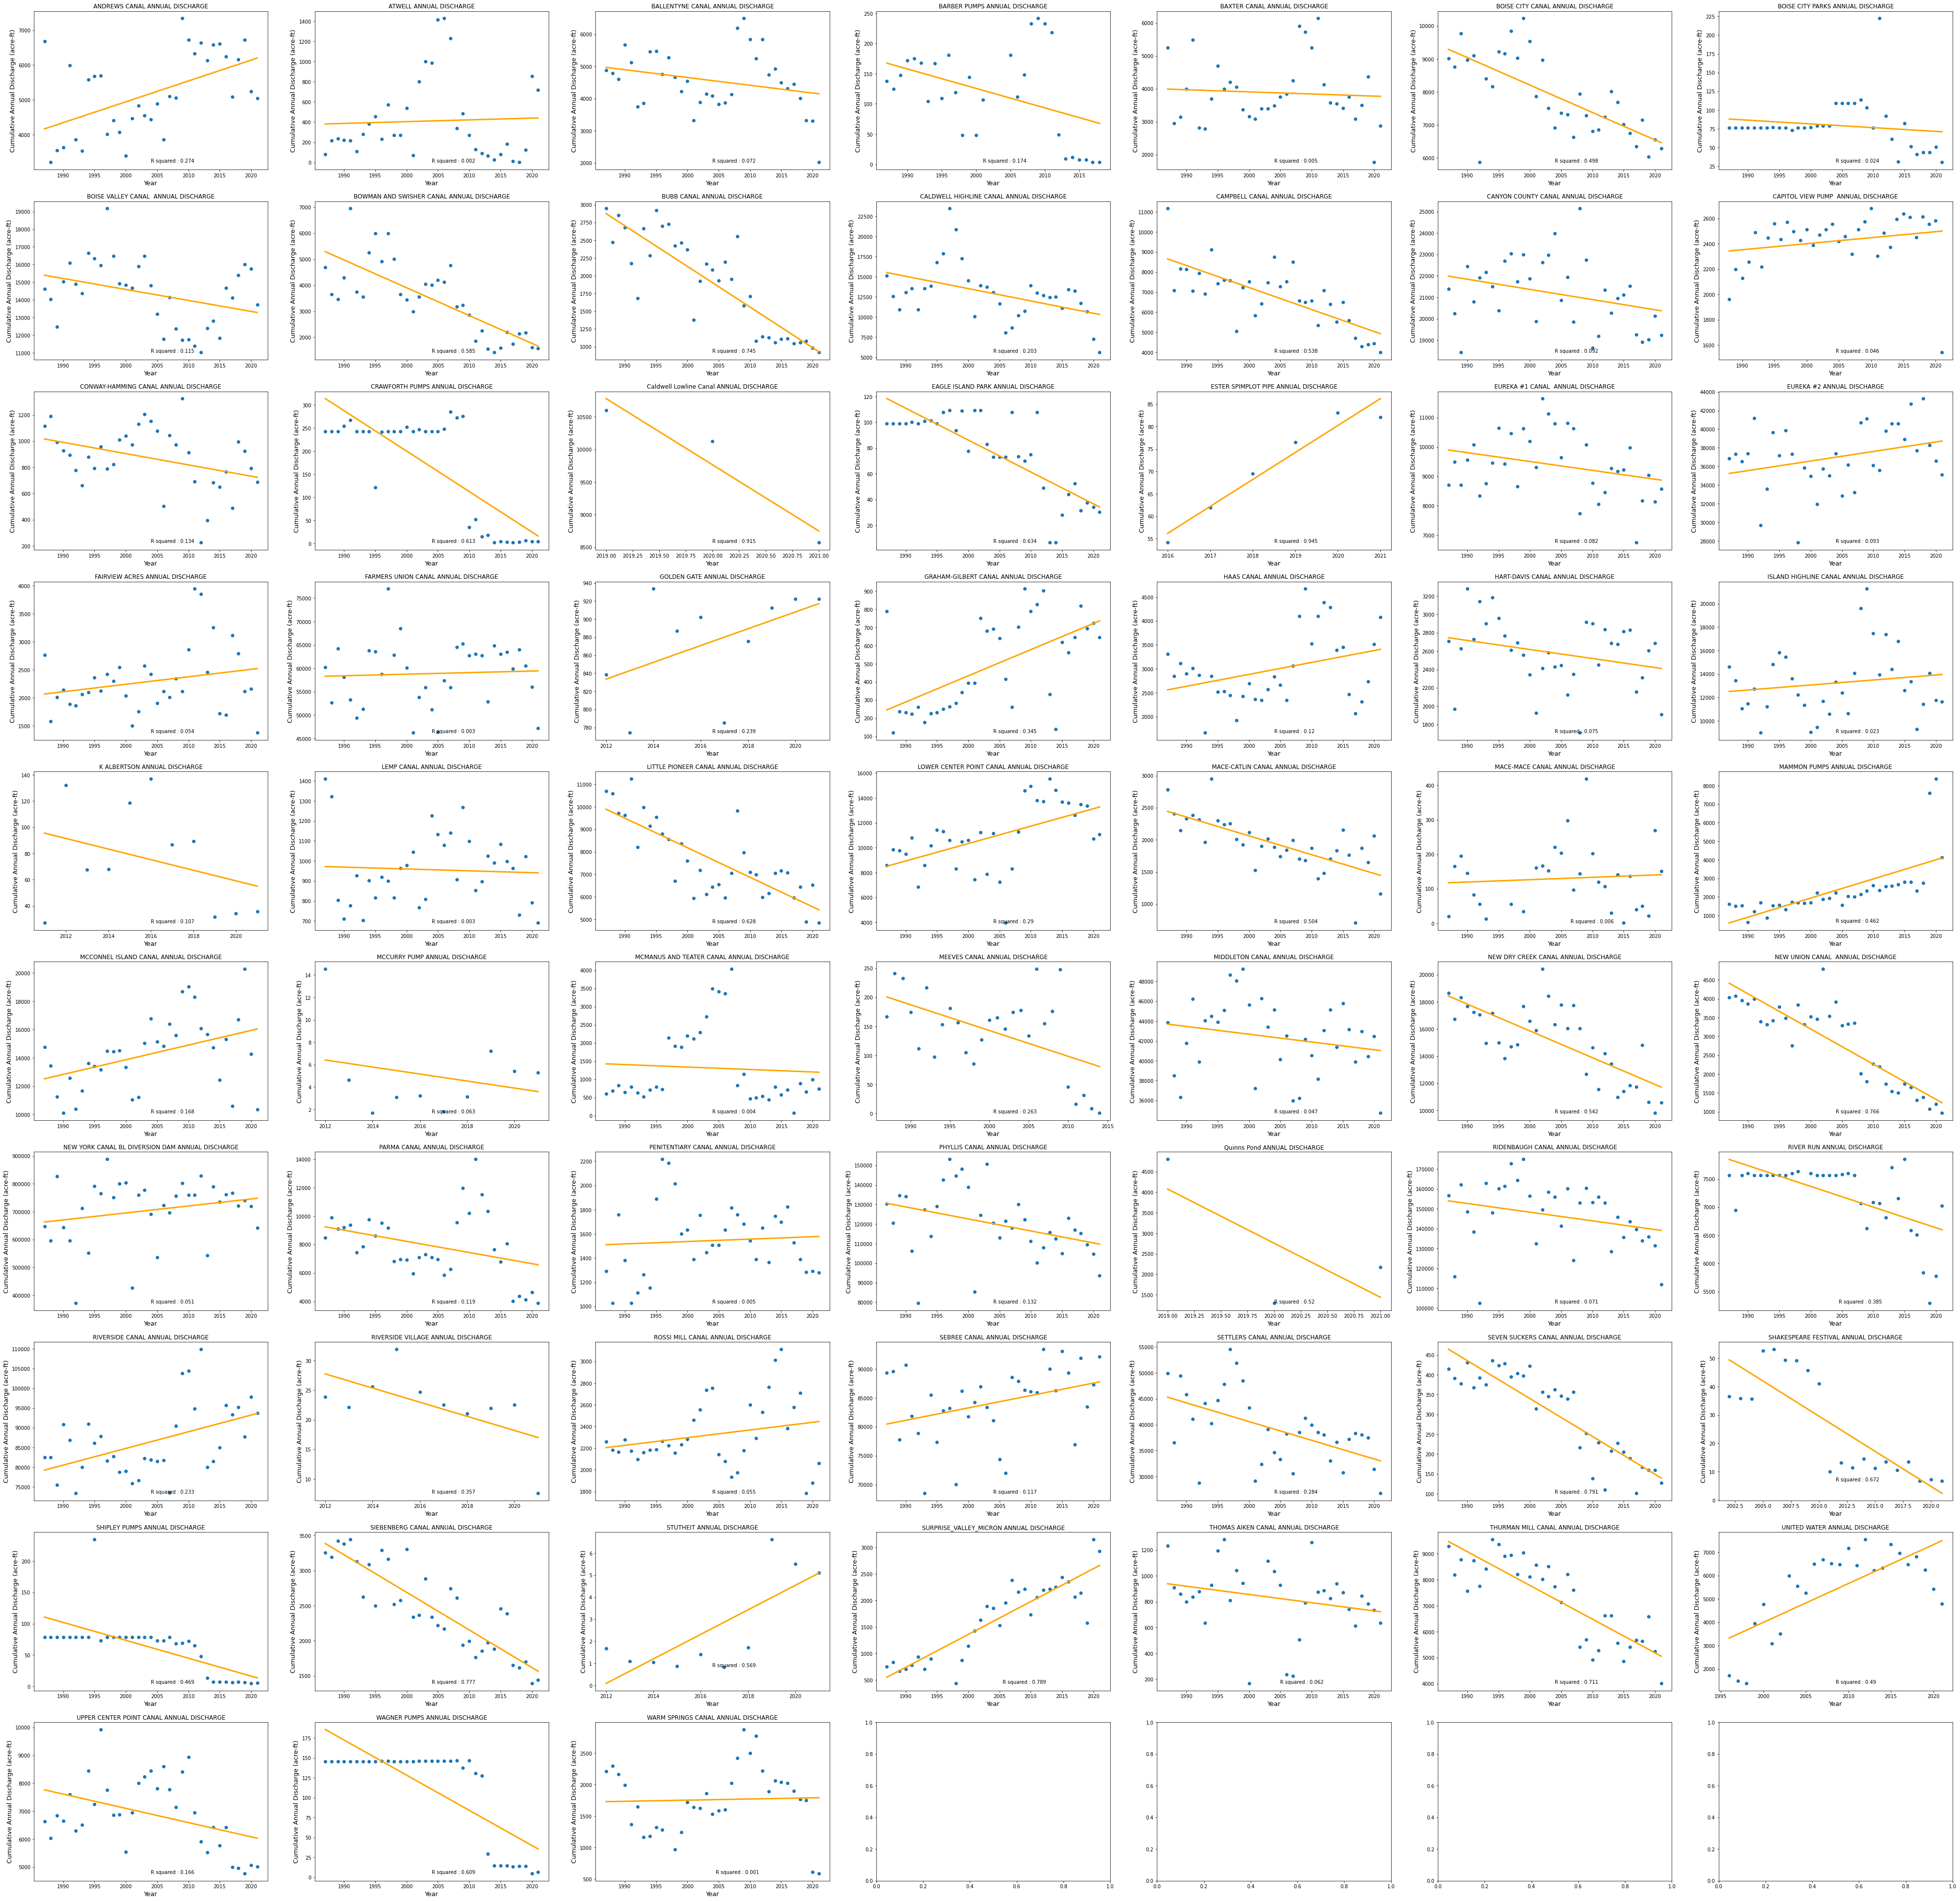

In [11]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###


tot = full_df.groupby([full_df['Year'],'Name']).sum(['Acre_feet'])   \
      .sort_values('Name').reset_index().rename(columns={'level_0':'Year'}).sort_values(['Name','Year'])  \
      .reset_index() #use group by to sum the daily values and drop extra columns
tot.loc[tot['Acre_feet'] == 0, 'Acre_feet'] = np.nan
tot = tot.drop(columns=['index'],axis=1).dropna().reset_index().drop(columns = ['index'], axis = 1)
names = tot['Name'].unique()

## CALCULATE A REGRESSION FOR EACH DRAIN ## 

regress = []
rsquared = np.empty(len(names))

for i in range(len(names)):
  df = pd.DataFrame(tot[tot['Name']==names[i]])
  mod = np.polyfit(df['Year'].values, df['Acre_feet'].values, deg=1) #calculates model coefficients
  df['Model'] = np.polyval(mod, df['Year'].values) #calculate model output values
  rsquared[i] = metrics.r2_score(df['Acre_feet'].values, df['Model'].values) #calculate rsquared for model
  regress.append(df)

regression= pd.concat(regress) #put list of dataframes into one

## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 7 #number of plots per row in figure
figure, ax = plt.subplots(10, plot_row, figsize=(70,70)) #create the figure

for n in range(len(names)): #run a for loop to add all plots to figure
  canal = regression[regression['Name']==names[n]]
  ax[i][j].plot(canal['Year'], canal['Acre_feet'], 'o')
  ax[i][j].plot(canal['Year'], canal['Model'], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (acre-ft)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(np.median(canal['Year']), np.min(canal['Acre_feet']), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/totals.png')

In [12]:
# Basic volume and timing stats #

vol_stat = full_df.groupby('Name').Acre_feet.agg(['mean', 'std']).reset_index().rename({'mean' : 'Avg Daily',
                                                                                        'std' : 'SD Daily'},
                                                                                      axis = 1)
tot_stat = tot.groupby('Name').Acre_feet.agg(['mean', 'std']).reset_index().rename({'mean' : 'Avg Total',
                                                                                    'std' : 'SD Total'},
                                                                                   axis = 1)
start_stat = survival.groupby('Name').StartDayofYear.agg(['mean', 'std']).reset_index().rename({'mean' : 'Avg Start',
                                                                                                'std' : 'SD Start'},
                                                                                              axis = 1)
end_stat = survival.groupby('Name').EndDayofYear.agg(['mean', 'std']).reset_index().rename({'mean' : 'Avg End',
                                                                                            'std' : 'SD End'},
                                                                                            axis = 1)

# Merge and export the files

stats = vol_stat.merge(tot_stat, on = 'Name', how = 'outer')
stats = stats.merge(start_stat, on = 'Name', how = 'outer')
stats = stats.merge(end_stat, on = 'Name', how = 'outer')

stats.to_csv('datasets/diversion_timeseries/final_stats/all_stats_102622.csv')

In [15]:
## --------------------------------------------------- ##
## EXPORT ANNUAL STATS (VOLUME AND TIMING) IN ONE FILE ##
## --------------------------------------------------- ##

out = tot.merge(survival, on = ['Year', 'Name'], how = 'outer', indicator = True)
out.to_csv('datasets/diversion_timeseries/final_stats/model_inputs_102622.csv') #EDIT for new ouput location

In [ ]:
## Test if time series is stationary ##
## --------------------------------- ##

## Mann_Kendall Test : A nonparametric test often used to detect changes in streamflow

# Test if volume time series is stationary
outs = []

for i in range(len(canals)):
  canal = canals[i]
  input = np.array(canal['CFS'])
  test = mk.seasonal_test(input, period=365, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_out = pd.DataFrame(outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
# display(mannkend_out)

# Test to see if annual time series is stationary 

annual_outs = []

for i in range(len(canals)):
  canal = canals[i]
  annual = totals[:,i]
  test = mk.original_test(annual, alpha = 0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  annual_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])
  
mannkend_annual = pd.DataFrame(annual_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_annual)
mannkend_annual.to_csv('datasets/diversion_timeseries/figures/mannkend_annual.csv')

# Test if length of irrigation season time series is stationary

length_outs = []

for i in range(len(canals)):
  canal = season_df[i]
  input = np.array(canal['Range'][canal['Range'] != 'NaN'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  length_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_length = pd.DataFrame(length_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])

# Test if centroid time series is stationary

centroid_outs = []

for i in range(len(canals)):
  canal = centroid_df[i]
  input = np.array(canal['CentroidDay'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  centroid_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_centroid = pd.DataFrame(centroid_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])




['BUBB CANAL']
['GRAHAM-GILBERT CANAL']
['LEMP CANAL']
['MACE-MACE CANAL']
['PENITENTIARY CANAL']
['SURPRISE_VALLEY_MICRON']
5
8
12


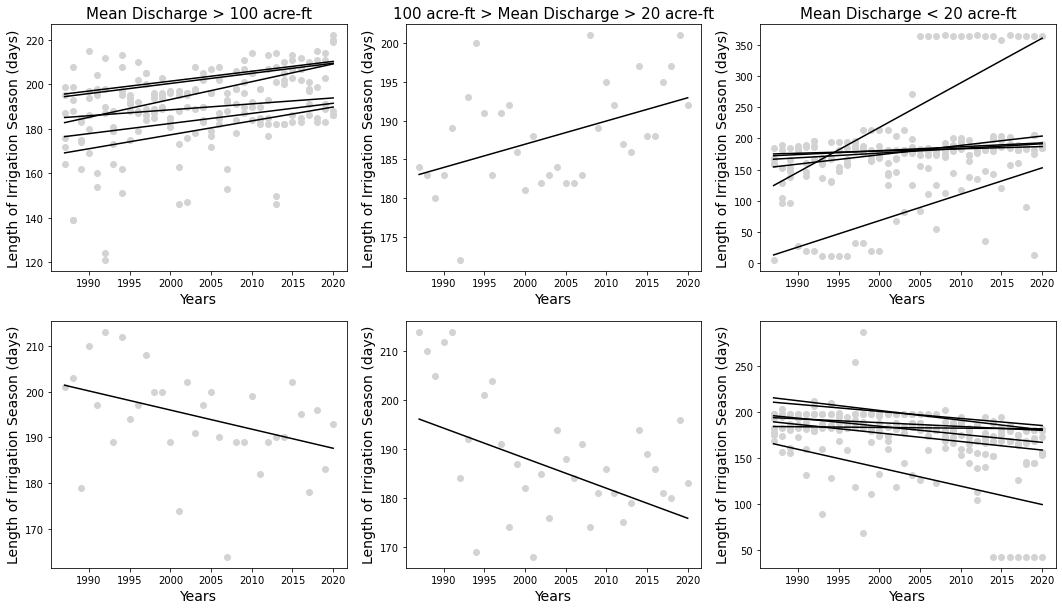

In [ ]:
## ---------------------------- ##
## CREATING FIGURES FOR RESULTS ## 
## ---------------------------- ##

figure, ax = plt.subplots(2, 3, figsize = (18,10))
year_slope = np.arange(0,34,1)
text = 'No increasing diversions'

for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  length = season_df[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'increasing':
    ax[0][0].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][0].set_xlabel('Years', size = 14)
    ax[0][0].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][0].set_title('Mean Discharge > 100 acre-ft', size=15)
  elif vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'decreasing':
    ax[1][0].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][0].set_xlabel('Years', size = 14)
    ax[1][0].set_ylabel('Length of Irrigation Season (days)', size=14)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'increasing':
    ax[0][1].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][1].set_xlabel('Years', size = 14)
    ax[0][1].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft', size = 15)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'decreasing':
    ax[1][1].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][1].set_xlabel('Years', size = 14)
    ax[1][1].set_ylabel('Length of Irrigation Season (days)', size=14)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'increasing':
    ax[0][2].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][2].set_xlabel('Years', size = 14)
    ax[0][2].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][2].set_title('Mean Discharge < 20 acre-ft', size=15)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'decreasing':
    ax[1][2].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][2].set_xlabel('Years', size = 14)
    ax[1][2].set_ylabel('Length of Irrigation Season (days)', size=14)
  else: 
    None

for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'increasing':
    ax[0][0].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'decreasing':
    ax[1][0].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'increasing':
    ax[0][1].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'decreasing':
    ax[1][1].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'increasing':
    print([canal['Name']])
    ax[0][2].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'decreasing':
    ax[1][2].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  else: 
    None

plt.savefig('datasets/diversion_timeseries/figures/results_length.svg')

notrend50 = []
notrend10 = []
notrend0 = []
for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'no trend':
    notrend50.append(canal)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'no trend':
    notrend10.append(canal)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'no trend':
    notrend0.append(canal)
  else: 
    None

print(len(notrend50))
print(len(notrend10))
print(len(notrend0))


5
8
12


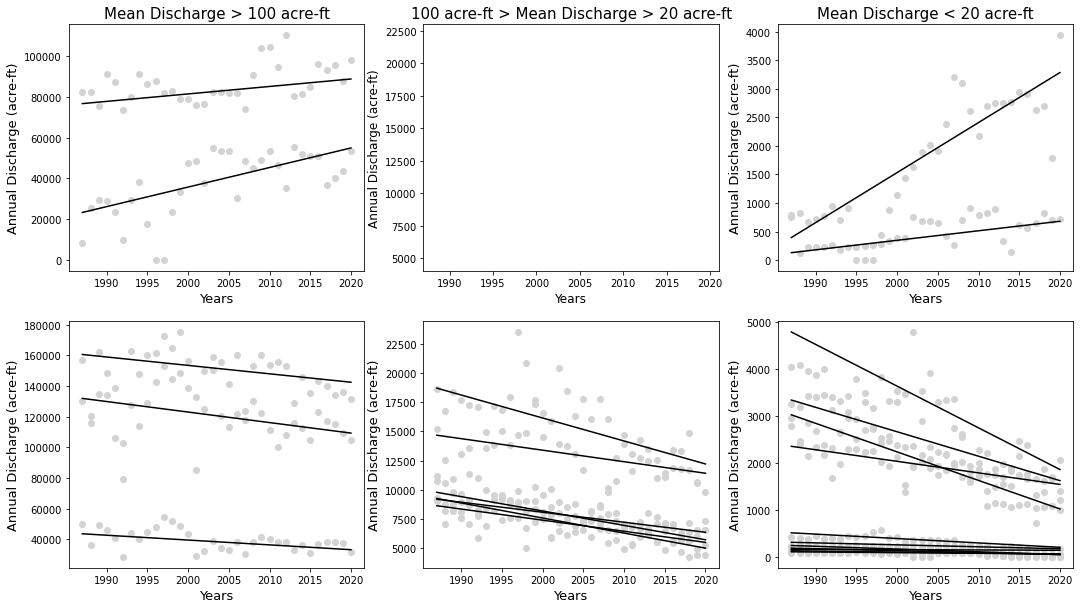

In [ ]:
## ---------------------------- ##
## CREATING FIGURES FOR RESULTS ## 
## ---------------------------- ##

## Change in Annual Volume Trends: 
figure, ax = plt.subplots(2, 3, figsize = (18,10))
year_slope = np.arange(0,34,1)
text = 'No increasing diversions'

for i in range(len(canals)):
  canal = base_stats.loc[i]
  ann_tots = totals[:,i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    ax[0][0].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][0].set_xlabel('Years', size = 13)
    ax[0][0].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][0].set_title('Mean Discharge > 100 acre-ft', size=15)
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    ax[1][0].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][0].set_xlabel('Years', size = 13)
    ax[1][0].set_ylabel('Annual Discharge (acre-ft)', size=13)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][1].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][1].set_xlabel('Years', size = 13)
    ax[0][1].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft')
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][1].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][1].set_xlabel('Years', size = 13)
    ax[1][1].set_ylabel('Annual Discharge (acre-ft)', size=13)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][2].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][2].set_xlabel('Years', size = 13)
    ax[0][2].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][2].set_title('Mean Discharge < 20 acre-ft', size=15)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][2].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][2].set_xlabel('Years', size = 13)
    ax[1][2].set_ylabel('Annual Discharge (acre-ft)', size=13)
  else: 
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft', size=15)
    ax[0][1].set_xlim([1987, 2021])
    ax[0][1].set_ylim([4000, 23000])
    ax[0][1].set_xlabel('Years', size=12)
    ax[0][1].set_ylabel('Annual Discharge (acre-ft)', size=12)
    # ax[0][1].text(1995, 17500, text)

for i in range(len(canals)):
  canal = base_stats.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    ax[0][0].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope),color='black')
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    ax[1][0].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][1].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope))
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][1].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][2].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][2].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  else: 
    None
plt.savefig('datasets/diversion_timeseries/figures/results_discharge.svg')

notrend50 = []
notrend10 = []
notrend0 = []
for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'no trend':
    notrend50.append(canal)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'no trend':
    notrend10.append(canal)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'no trend':
    notrend0.append(canal)
  else: 
    None

print(len(notrend50))
print(len(notrend10))
print(len(notrend0))


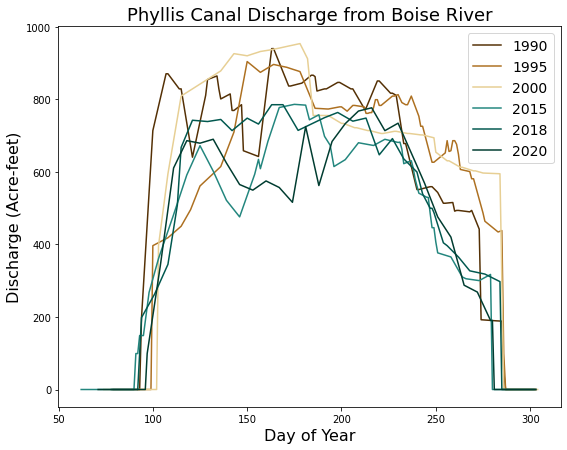

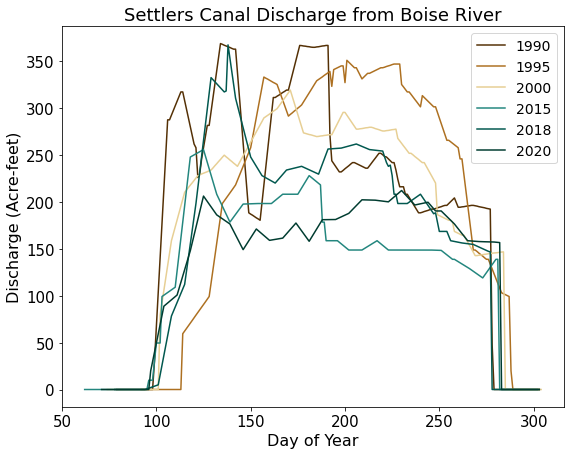

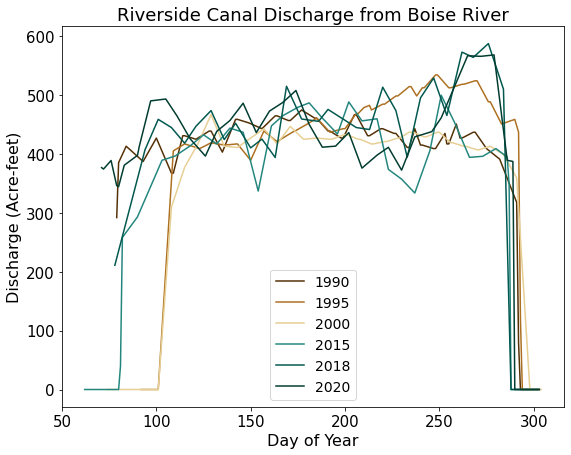

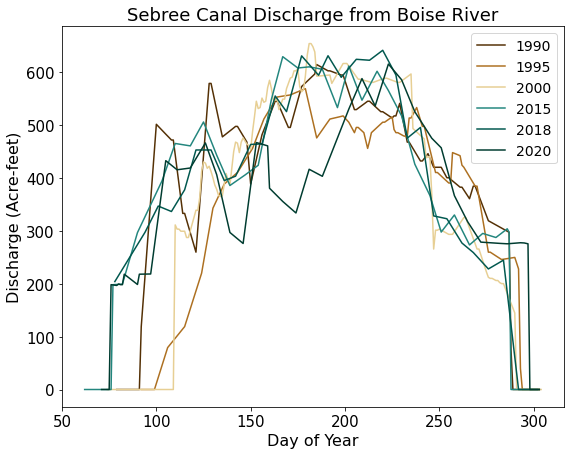

Text(0.5, 0, 'Day of Year')

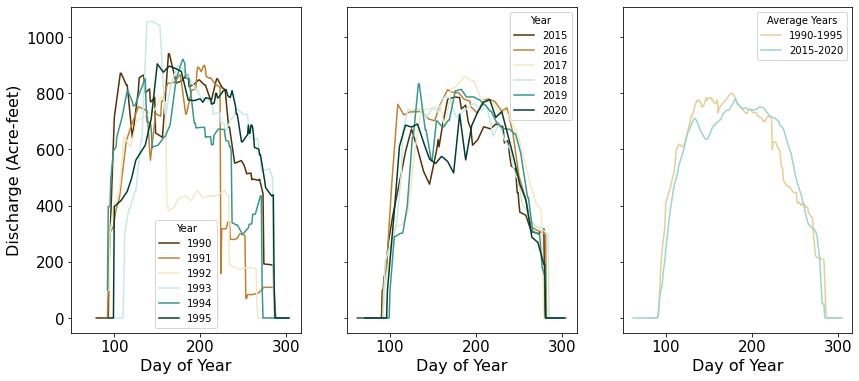

In [ ]:
# Create plots to look at how the discharge has changed through time
# At certain canals

names = full_df['Name'].unique()
pull = ['PHYLLIS CANAL', 'SETTLERS CANAL', 'RIVERSIDE CANAL', 'SEBREE CANAL']
years = [1990, 1995, 2000, 2015, 2018, 2020]

dfs = []
for i in pull:
  dfs.append(full_df[full_df['Name'] == i])
  
#Subset to specific years to plot
pioneer = dfs[0].loc[dfs[0]['Year'].isin(years)]
settlers = dfs[1].loc[dfs[1]['Year'].isin(years)]
riverside = dfs[2].loc[dfs[2]['Year'].isin(years)]
sebree = dfs[3].loc[dfs[3]['Year'].isin(years)]

# Pioneer figure
plt.figure(figsize = (9,7))
sns.lineplot(x = pioneer['DayofYear'],
             y = pioneer['Acre_feet'],
             hue = pioneer['Year'],
             legend = 'full',
             palette = 'BrBG')
plt.ylabel('Discharge (Acre-feet)', size =16)
plt.xlabel('Day of Year', size = 16)
plt.legend(fontsize=14)
plt.title('Phyllis Canal Discharge from Boise River', size=18)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.show()

# Settlers Figures
plt.figure(figsize = (9,7))
sns.lineplot(x = settlers['DayofYear'],
             y = settlers['Acre_feet'],
             hue = settlers['Year'],
             legend = 'full',
             palette = 'BrBG')
plt.ylabel('Discharge (Acre-feet)', size =16)
plt.xlabel('Day of Year', size = 16)
plt.legend(fontsize=14)
plt.title('Settlers Canal Discharge from Boise River', size=18)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.show()

## Riverside Canal

plt.figure(figsize = (9,7))
sns.lineplot(x = riverside['DayofYear'],
             y = riverside['Acre_feet'],
             hue = riverside['Year'],
             legend = 'full',
             palette = 'BrBG')
plt.ylabel('Discharge (Acre-feet)', size =16)
plt.xlabel('Day of Year', size = 16)
plt.legend(fontsize=14)
plt.title('Riverside Canal Discharge from Boise River', size=18)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.show()

## Sebree Canal

plt.figure(figsize = (9,7))
sns.lineplot(x = sebree['DayofYear'],
             y = sebree['Acre_feet'],
             hue = sebree['Year'],
             legend = 'full',
             palette = 'BrBG')
plt.ylabel('Discharge (Acre-feet)', size =16)
plt.xlabel('Day of Year', size = 16)
plt.legend(fontsize=14)
plt.title('Sebree Canal Discharge from Boise River', size=18)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.show()

# Compare pioneer
old = [1990, 1991, 1992, 1993, 1994, 1995]
new = [2015, 2016, 2017, 2018, 2019, 2020]
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,6), sharex=True, sharey=True)
sns.lineplot(x = dfs[0]['DayofYear'].loc[dfs[0]['Year'].isin(old)],
             y = dfs[0]['Acre_feet'].loc[dfs[0]['Year'].isin(old)],
             hue = dfs[0]['Year'].loc[dfs[0]['Year'].isin(old)],
             ax = ax1,
             palette = 'BrBG')
sns.lineplot(x = dfs[0]['DayofYear'].loc[dfs[0]['Year'].isin(new)],
             y = dfs[0]['Acre_feet'].loc[dfs[0]['Year'].isin(new)],
             hue = dfs[0]['Year'].loc[dfs[0]['Year'].isin(new)],
             ax = ax2,
             palette = 'BrBG')
old_avg = dfs[0].loc[dfs[0]['Year'].isin(old)].groupby('DayofYear').mean()
new_avg = dfs[0].loc[dfs[0]['Year'].isin(new)].groupby('DayofYear').mean()
old_avg['Average Years'] = '1990-1995'
new_avg['Average Years'] = '2015-2020'
avgs = pd.concat([old_avg,new_avg]).reset_index()
sns.lineplot(x = avgs['DayofYear'],
             y = avgs['Acre_feet'],
             hue = avgs['Average Years'],
             ax = ax3,
             palette = 'BrBG')
plt.ylabel('Discharge (Acre-feet)', size=16)
plt.xlabel('Day of Year', size = 16)
ax1.set_ylabel('Discharge (Acre-feet)', size=16)
ax1.set_xlabel('Day of Year', size = 16)
ax2.set_xlabel('Day of Year', size = 16)
